In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython

import copy
import itertools
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import msprime
import numpy as np
import pandas as pd
import random
import toytree

from collections import Counter

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

0

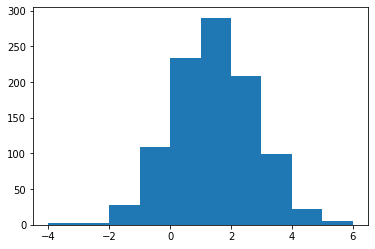

In [2]:
def bm(mean, var, dt, log=True, dtype="int"):
    ret = 0
    mean = np.float(mean)
    if dtype == "int":
        # Avoid log(1)
        if not log or mean <= 1:
            ret = np.int(np.round(np.random.normal(mean, var*dt)))
        else:
            try:
                ret = np.int(np.round(np.exp(np.random.normal(np.log(mean), var*dt))))
            except:
                import pdb; pdb.set_trace()

    elif dtype == "float":
        ret = np.random.normal(mean, var*dt)
    else:
       raise Exception("bm dtype must be 'int' or 'float'. You put: {}".format(dtype))
    return ret

def prune(tre, verbose=False):
    ttree = tre.copy()
    tips = ttree.treenode.get_leaves()
    
    if np.any(np.array([x.height for x in tips]) > 0):
        for t in tips:
            if not np.isclose(t.height, 0):
                if verbose: print("Removing node/height {}/{}".format(t.name, t.height))
                t.delete(prevent_nondicotomic=False)
                ttree = prune(ttree)
    return ttree

ones = np.ones(1000)
plt.hist(list(map(lambda x: bm(x, 0.7, 2), ones)))
bm(1, .7, 5, log=True)

In [3]:
bdtre = toytree.rtree.bdtree(b=1, d=0.7, ntips=10, retain_extinct=False, verbose=True)
bdtre.draw(node_labels="idx")
for i in range(5):
    tre = toytree.rtree.bdtree(b=1, d=.9, ntips=10)

Birth events 19
Extinctions 5 (per birth 0.2631578947368421)
0.6824001547642392
1.6663376190028987
1.7227851607277274
2.2325113223397643
0.14260905200930443


<svg class="toyplot-canvas-Canvas" height="275.0px" id="tceca43a77ac9484eaa224d77ac2a075d" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 260.0 275.0" width="260.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 10 11 12 13 14 15 16 17 18

# Current working bdtree sim

In [253]:
# Should we implement a death rate parameter too? If ancestral abundance is super high
# which we'd expect if we're dividing at each branch, then the extinction rate is really
# low
#
def bdtree_ibm(b=1, stop="taxa", n=50, t=4, feature_dict=None, process="abundance",
               alpha=0, speciation_rate_shifts=False, verbose=False):
    if not feature_dict:
        # Each species has a dictionary of features, these are the default values
        #  abundance - Abundance of the species
        #  r - Rate at which abundance changes, can be negative
        #  trait - This is a random trait value that evolves by BM
        #  lambda - Per lineage speciation rate
        feature_dict = {"abundance":{"sigma":0.1, "zbar_0":50000, "log":True, "dtype":"int"},
                      "r":{"sigma":0.01, "zbar_0":0, "log":False, "dtype":"float"},
                      "trait":{"sigma":2, "zbar_0":0, "log":False, "dtype":"float"},
                      "lambda_":{"sigma":0.1, "zbar_0":b, "log":False, "dtype":"float"}
                     }

    tre = toytree.tree()
    for fname, fdict in feature_dict.items():
        tre.treenode.add_feature(fname, fdict["zbar_0"])

    taxa_stop = n
    time_stop = t

    ext = 0
    evnts = 0
    t = 0
    while(1):

        ## Get list of extant tips
        tips = tre.treenode.get_leaves()

        # Sample time interval
        if speciation_rate_shifts:
            lambs = np.array([tip.lambda_ for tip in tips])
            # Run a horse race for all lineages, smallest time sampled wins
            ts = np.random.exponential(lambs)
            idx = np.where(ts == ts.min())[0][0]
            dt = ts.min()
            sp = tips[idx]
        else:
            # This isn't strictly necessary, because if the rate shift model
            # is turned off then all tips will have equal lambda and equal
            # probability of being sampled, but keeping this here for now
            # for the hell of it.
            dt = np.random.exponential(1/(len(tips) * b))
            sp = np.random.choice(tips)

        t = t + dt
        evnts += 1

        c1 = sp.add_child(name=str(t)+"1", dist=0)
        c2 = sp.add_child(name=str(t)+"2", dist=0)
        try:
            # Always have at least 1 individual for each daughter species
            # Raises ValueError if sp.abundanc == 1
            abund = np.random.randint(1, sp.abundance)
        except ValueError as inst:
            # If a species of abundance 1 speciates we need to allow this
            sp.abundance = 2
            abund = 1

        for c in [c1, c2]:
            for fname, fdict in feature_dict.items():
                c.add_feature(fname, fdict["zbar_0"])
                
        c1.add_feature("abundance", abund)
        c2.add_feature("abundance", sp.abundance-abund)


        # Update branch length, evolve features, and update abundance
        tips = tre.treenode.get_leaves()
        for x in tips:
            x.dist += dt
            if process == "abundance":
                # If 'abundance' log species abundances change via Brownian motion
                for fname, fdict in feature_dict.items():
                    x.add_feature(fname, bm(getattr(x, fname),
                                            fdict["sigma"],
                                            dt=dt,
                                            log=fdict["log"],
                                            dtype=fdict["dtype"]))
            elif process == "rate":
                for fname, fdict in feature_dict.items():
                    # Update 'lambda_', 'r' and 'trait', but skip 'abundance'
                    #import pdb; pdb.set_trace()
                    if fname == "abundance": continue
                    x.add_feature(fname, bm(getattr(x, fname),
                                            fdict["sigma"],
                                            dt=dt,
                                            log=fdict["log"],
                                            dtype=fdict["dtype"]))
                    # Apply the population size change
                    x.abundance = int(x.abundance * (np.exp(x.r)**dt))
            else:
                raise Exception("process must be 'abundance' or 'rate'. You put {}".format(process))

        # Check boundary conditions for abundance and lambda
        for x in tips[:]:
            # Check extinction and prune out extinct and any resulting hanging branches
            # If you're the only individual left, you have nobody to mate with so you die.
            if x.abundance <= 1:
                tips.remove(x)
                if len(tips) == 0:
                    # Can't prune to an empty tree, so simply return a new empty tree
                    tre = toytree.tree()
                else:
                    tre.treenode.prune(tips, preserve_branch_length=True)
                ext += 1

            # The speciation rate can't be negative
            elif x.lambda_ < 0:
                x.lambda_ = 0

        ## This shouldn't be necessary now that we're using the treenode.prune() method
        tre = prune(tre)

        tips = tre.treenode.get_leaves()
        # Check stopping criterion
        done = False
        if stop == "taxa":
            if len(tips) >= taxa_stop:
                done = True
        elif stop == "time":
            if t >= time_stop:
                done = True
        if len(tips) == 1 and tips[0].name == '0':
            print("All lineages extinct")
            done = True
        if done:
            if verbose:
                print("ntips {}".format(len(tips)))
                print("time {}".format(t))
                print("Birth events {}".format(evnts))
                print("Extinctions (per birth) {} ({})".format(ext, ext/evnts))
            tre._coords.update()
            for i, t in enumerate(tips[::-1]):
                t.name = "r{}".format(i)
            return tre


tre = bdtree_ibm(b=0.2, stop="taxa", n=20, t=5, process="abundance", speciation_rate_shifts=False, verbose=True, alpha=0)
tre.draw()

ntips 20
time 20.628009031039916
Birth events 19
Extinctions (per birth) 0 (0.0)
0.8132417563446563


(<toyplot.canvas.Canvas at 0x7f79f9bc1908>,
 <toyplot.coordinates.Cartesian at 0x7f79f9ba1898>)

<svg class="toyplot-canvas-Canvas" height="360.0px" id="ta88723f3508c42489d26eca50e799060" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 265.0 360.0" width="265.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 r10 r11 r12 r13 r14 r15 r16 r17 r18 r19

# Fancy up the tip labels

In [ ]:
tips = tre.treenode.get_leaves()
for feat in ["abundance", "lambda_"]:
    labs = np.array([getattr(x, feat) for x in tips])
    if feat == "abundance":
        labc = np.log(labs + np.finfo(float).eps)
        labc = labs
    else:
        labc = labs
    labc = labc - labc.min()
    labc = (labc/labc.max())
    cmap = cm.get_cmap("jet")
    cs = [cmap(float(x)) for x in labc]
    # tip labels _must_ be string
    labs = [str(x) for x in labs]
    labc = [str(x) for x in labc]
    tre.draw(tip_labels=labc, node_labels=False, tip_labels_colors=cs, width=500, height=500) 
# Iff one species remains and you try to 'draw()' you get this error
# can generate by setting abundance very low. not sure why it's doing this yet.
# 'list' object has no attribute 'shape'

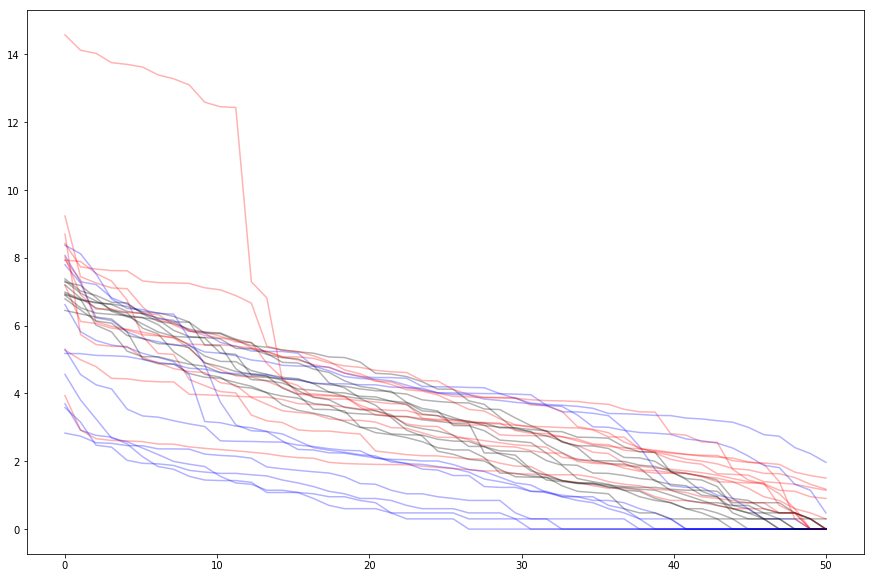

In [266]:
fig, ax = plt.subplots(figsize=(15, 10))
for _ in range(10):
    xs = np.linspace(0, len(abunds), len(abunds))

    for c, p in zip(["red", "blue"], ["rate", "abundance"]):
        tre = bdtree_ibm(b=.2, stop="taxa", n=50, t=4, process=p, verbose=False)
        tips = tre.treenode.get_leaves()
        abunds = np.array([x.abundance for x in tips])
        abunds = sorted(abunds, reverse=True)
        ys = np.log10(abunds)
        plt.plot(xs, ys, c=c, alpha=0.3)

    ys = np.log10(sorted(np.random.logseries(0.9999999, size=len(abunds)), reverse=True))
    plt.plot(xs, ys, c='black', alpha=0.3)

## This is the "working" bd_ibm using only split abundances
Doesn't have the abundance rate change parameter

In [148]:
# Should we implement a death rate parameter too? If ancestral abundance is super high
# which we'd expect if we're dividing at each branch, then the extinction rate is really
# low
def bd_ibm(b=1, stop="taxa", n=50, t=4, sigma=1, abundance=500000, verbose=False):

    tre = toytree.tree()
    tre.treenode.add_feature("abundance", abundance)

    taxa_stop = n
    time_stop = t

    ext = 0
    evnts = 0
    t = 0
    while(1):
        tips = tre.treenode.get_leaves()
        # Check extinction
        for x in tips[:]:
            if x.abundance <= 0:
                tips.remove(x)
                tre.treenode.prune(tips, preserve_branch_length=True)
                # x.delete(preserve_branch_length=True, prevent_nondicotomic=False)
                ext += 1
        tre = prune(tre)

        ## Get list of extant tips
        tips = tre.treenode.get_leaves()

        # Sample time interval
        dt = np.random.exponential(1/(len(tips) * b))
        t = t + dt
        evnts += 1
        
        sp = np.random.choice(tips)
        c1 = sp.add_child(name=str(t)+"1", dist=0)
        c2 = sp.add_child(name=str(t)+"2", dist=0)
        try:
            # Always have at least 1 individual for each daughter species
            abund = np.random.randint(1, sp.abundance)
        except Exception as inst:
            # If a species of abundance 1 speciates we need to allow this
            sp.abundance = 2
            abund = 1
        c1.add_feature("abundance", abund)
        c2.add_feature("abundance", sp.abundance-abund)

        # Update branch length and perturb abundance
        tips = tre.treenode.get_leaves()
        for x in tips:
            x.dist += dt
            x.abundance = bm(x.abundance, sigma, dt, log=True)

        # Check stopping criterion
        done = False
        if stop == "taxa":
            if len(tips) >= taxa_stop:
                done = True
        elif stop == "time":
            if t >= time_stop:
                done = True
        elif len(tips) == 1 and tre.treenode.get_leaves()[0].name == '0':
            print("All lineages extinct")
            done = True
        if done:
            if verbose:
                print("Time {}".format(t))
                print("Ntips {}".format(len(tips)))
                print("Birth events {}".format(evnts))
                print("Extinctions (per birth) {} ({})".format(ext, ext/evnts))
            tre._coords.update()
            for i, t in enumerate(tips[::-1]):
                t.name = "r{}".format(i)
            return tre


tre = bd_ibm(b=.2, stop="taxa", n=20, t=10, sigma=.7, abundance=1, verbose=True)

tips = tre.treenode.get_leaves()
abunds = [str(x.abundance) for x in tips]
tre.draw(tip_labels=abunds)
tre.draw()
# Iff one species remains and you try to 'draw()' you get this error
# can generate by setting abundance very low. not sure why it's doing this yet.
# 'list' object has no attribute 'shape'

Time 33.07767729533183
Ntips 20
Birth events 31
Extinctions (per birth) 12 (0.3870967741935484)


(<toyplot.canvas.Canvas at 0x7fc7c2f93240>,
 <toyplot.coordinates.Cartesian at 0x7fc7c2f93e10>)

<svg class="toyplot-canvas-Canvas" height="360.0px" id="tab8244c70d7141ea9d895d34f55d5776" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 260.0 360.0" width="260.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 1 10 2 1 1 2 1 1 1 1 1 4 26 1 1 1 2 9 14 1

<svg class="toyplot-canvas-Canvas" height="360.0px" id="t56a4ed0f55f24ae09c2599e44cbf17d3" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 265.0 360.0" width="265.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> r0 r1 r2 r3 r4 r5 r6 r7 r8 r9 r10 r11 r12 r13 r14 r15 r16 r17 r18 r19

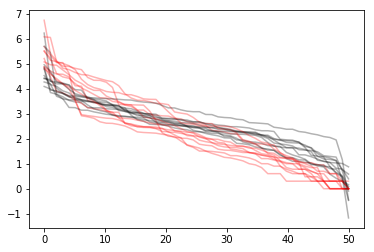

In [28]:
# abundance only bd tree
for _ in range(10):
    
    tre = bd_rate(b=.2, stop="taxa", n=50, t=4, sigma=0.5, abundance=10000, verbose=False)
    tips = tre.treenode.get_leaves()
    abunds = np.array([x.abundance for x in tips])
    #plt.hist(np.log10(abunds), bins=20)
    abunds = sorted(abunds, reverse=True)
    xs = np.linspace(0, len(abunds), len(abunds))
    ys = np.log10(abunds)
    plt.plot(xs, ys, c="red", alpha=0.3)

    plt.plot(xs, np.log(sorted(np.random.lognormal(2.5, 1, len(abunds)), reverse=True)), c='black', alpha=0.3)

## Reading simulations
Use `PIED.util.load_sim()`

## Trash below here

In [184]:
# This works, but the notion of time is fucked up, it's not
# per lineage, it's per birth event.
def bd_timesteps(steps=50, abundance=500000):
    tre = toytree.tree()
    tre.treenode.add_feature("abundance", abundance)

    for s in range(steps):
        tips = tre.treenode.get_leaves()

        # Check extinction
        for x in tips:
            if x.abundance <= 0:
                x.delete(preserve_branch_length=True, prevent_nondicotomic=False)

        tips = tre.treenode.get_leaves()
        sp = np.random.choice(tips)
        #sp.dist += 1
        c1 = sp.add_child(name=str(s)+"1", dist=0)
        c2 = sp.add_child(name=str(s)+"2", dist=0)
        abund = np.random.randint(1, sp.abundance)
        c1.add_feature("abundance", abund)
        c2.add_feature("abundance", sp.abundance-abund)

        # Update branch length and perturb abundance
        for x in tips:
            x.dist += 1
            x.abundance = bm(x.abundance, 100, log=False)

        tre = prune(tre)
    return tre
tre = bd_timesteps()
tre.draw()

(<toyplot.canvas.Canvas at 0x7f52a722fda0>,
 <toyplot.coordinates.Cartesian at 0x7f52a71e3208>)

<svg class="toyplot-canvas-Canvas" height="702.0px" id="td5c7649a9fe94654a29b9d312af88761" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 265.0 702.0" width="265.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 342 392 391 132 422 421 142 442 441 82 262 431 291 332 462 461 361 411 482 481 471 492 491 122 372 371 322 321 402 401 252 382 452 451 231 192 191 172 311

0.0 10.349774655164547
0.0 1.0
0.0 1.3833030189140958
0.0 1.0


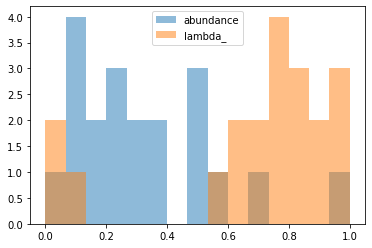

<svg class="toyplot-canvas-Canvas" height="1500.0px" id="t3c148fe558864a4ca292c1b823bac422" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 500.0 1500.0" width="500.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 1000000 32215 4159 4689 235 1513 450 7028 32 66 194 485 87 1052 676 79 109 429 9641 653 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38

<svg class="toyplot-canvas-Canvas" height="1500.0px" id="t266ae5b513de436fab704ccc90c2317d" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 500.0 1500.0" width="500.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> 0.07393711807153464 0.2517084301344119 0.25348565672972045 0.18780149524613965 0.0635612635790049 0.17275821199225969 0.21700005028117353 0.14982437112949276 0.1355514908718916 0.17715254574140088 0.06404163424586953 0.1965074154909469 0.18218140825887102 0.1545555330810069 0.16422791955624783 0.24583772813318214 0.18900073220969402 0.22684815661425475 0.20184478755718965 0.20201013445057617 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38

In [257]:
tre.treenode.get_leaves()
for feat in ["abundance", "lambda_"]:
    labs = np.array([getattr(x, feat) for x in tips])
    labc = np.log(labs)
    labc = labc - labc.min()
    print("{} {}".format(labc.min(), labc.max()))
    labc = (labc/labc.max())
    print("{} {}".format(labc.min(), labc.max()))
    cmap = cm.get_cmap("jet")
    cs = [cmap(float(x)) for x in labc]
    # tip labels _must_ be string
    labs = [str(x) for x in labs]
    plt.hist(labc, label=feat, bins=15, alpha=0.5)
    labc = [str(x) for x in labc]
    tre.draw(tip_labels=labs, node_labels="idx", tip_labels_colors=cs, width=500, height=1500) 
plt.legend()